In this notebook we will explore the dataset

In [83]:
# python system
import os
import csv
# jupyter utils
from IPython.display import display

import pandas as pd
import numpy as np

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.express as px
init_notebook_mode(connected=True)

# local modules
from utils import load_dataset, clean_dataset

%matplotlib inline

In [2]:
%%time
df = load_dataset()

CPU times: user 4.52 s, sys: 1.36 s, total: 5.88 s
Wall time: 5.88 s


In [3]:
%%time
df = load_dataset(time_to_datetime=True)

CPU times: user 2min 30s, sys: 2.14 s, total: 2min 32s
Wall time: 2min 32s


In [4]:
df = clean_dataset(df)

In [5]:
display(df.head(3))
display(df.shape)

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,False,False,New Haven,2013-10-01,new haven,V,262,True,N,Stop Sign,31.0,H,W,M,True
1,False,False,State Police,2013-10-01,willington,V,1000002715,False,N,Other,29.0,M,W,M,False
2,False,False,Plymouth,2013-10-01,terryville,V,21,True,N,Speed Related,18.0,N,W,M,True


(2473643, 15)

# TARGET VARIABLE

In [84]:
# plotly bar plot
# of ContrabandIndicator column 

contraband_distribution = (df.ContrabandIndicator.value_counts(normalize=True) * 100).round(1).apply(lambda v: str(v)+'%').reset_index()

fig = px.bar(contraband_distribution, x='index', y='ContrabandIndicator')

fig.update_layout(
    title={
        'text': "Contraband Distribution",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Contraband Found",
    yaxis_title="Percentage of cases"
    
)

fig.show()

# POLICE DEPARTMENTS

In [85]:
departments_freq = (df['Department Name'].value_counts(normalize=True) * 100)\
                    .round(2)\
                    .sort_values(ascending=True)\
                    .tail(10)
data = [
    go.Bar(
        y=departments_freq.index,
        x=departments_freq,
        orientation='h',
    )]
layout = go.Layout(
    height=800,
    title=f'Car searches of top {departments_freq.size} police departments ({df["Department Name"].nunique()} unique departments in total)',
    hovermode='closest',
    xaxis=dict(title='Frequency (%)', ticklen=5, zeroline=False, gridwidth=2, domain=[0.1, 1]),
    yaxis=dict(title='Departments', ticklen=5, gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

**State Police** does the most searches by a large margin.

In [86]:
departments_freq = df['Department Name'].value_counts(normalize=False).sort_values(ascending=True).head(5)
data = [
    go.Bar(
        y=departments_freq.index,
        x=departments_freq,
        orientation='h'
    )]
layout = go.Layout(
    height=800,
    title=f'Car searches of bottom {departments_freq.size} police departments',
    hovermode='closest',
    xaxis=dict(title='Count', ticklen=5, zeroline=False, gridwidth=2, domain=[0.1, 1]),
    yaxis=dict(title='Departments', ticklen=5, gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Some departments have a really low number of searches. These departments will be very difficult to follow the requirements requested by the client, namely:
- A minimum 50% success rate for searches;
- No police sub-department should have a discrepancy bigger than 5% in success rate on the protected classes.

# Locations

In [87]:
df.InterventionLocationName.nunique()

1845

At first sight there seems to be about 1845 different locations.

A lot of the locations are streets while others are city names. It would be beneficial to separate both so that we understand what we can do with the cities.

To separate cities from specific locations, we will filter the locations which only occur a small number of times. We presume most of those will be street names or very specific locations which we can't do much about.

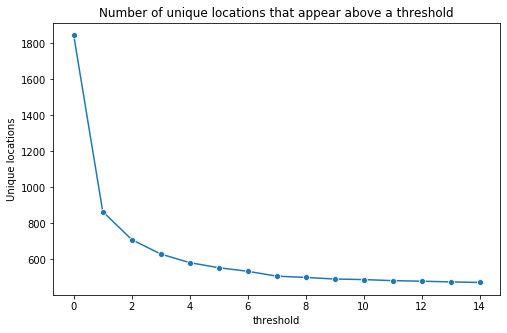

In [88]:
def separate_locations_above_threshold(df: pd.DataFrame, threshold: int) -> list:
    """
    Returns two lists. The first one with the locations whose appearance in df are below the threshold,
    and the second one with the rest of the locations
    """
    locations_freq_df = df.InterventionLocationName.value_counts().to_frame().reset_index().rename(columns={'index':'location','InterventionLocationName':'value'})
    locations_above_threshold = locations_freq_df.loc[locations_freq_df.value > threshold, 'location'].values.tolist()
    locations_below_threshold = locations_freq_df.loc[locations_freq_df.value <= threshold, 'location'].values.tolist()
    return (locations_below_threshold, locations_above_threshold)

threshold_list = list(range(0,15))
n_locations_list = []
for thrs in threshold_list:
    locations = separate_locations_above_threshold(df,thrs)[1]
    n_locations = len(locations)
    n_locations_list.append(n_locations)

plt.figure(figsize=(8,5))
sns.lineplot(x=threshold_list,y=n_locations_list,marker='o')
plt.title('Number of unique locations that appear above a threshold')
plt.xlabel('threshold')
plt.ylabel('Unique locations')
plt.savefig(os.path.join('media','LocationsRemainingAfterFilteringByFrequency.png'))


Just by removing locations which only appear once, we dropped 1000 locations! That's 40% less locations than what we previously had. We decide to only drop those with one appearance to be sure it is only specific locations that can't be determined whose city they belong to.

We can analyse the locations that were left behind:

In [89]:
threshold_chosen = 1
locations_left_behind = separate_locations_above_threshold(df,threshold_chosen)[0]
locations_left_behind

['highland @ high',
 'kennedy drive/ winst',
 'e main / dible',
 'east main st @ dibbl',
 'kennedy drive/commer',
 'e main st at willow ',
 'riverside/highland',
 'wadhams ave.',
 'high st & culvert st',
 'e. main st./ buena v',
 'e. main st @ pinerid',
 '322 east main street',
 'alnaby / torringford',
 'pulaski dr',
 'weth',
 'main  st.',
 'commercial/kennedy',
 'ansoonia',
 'new harwinton road/c',
 'grove at east elm',
 ' ',
 'central/apple',
 'southb main st',
 'east main / durand',
 'morse',
 'church at high st',
 'west[prt',
 'pearl street near ma',
 ' ledyard',
 'mcdermott ave. & far',
 'main street near far',
 'water street at john',
 'east main / griswold',
 'torringford west/pil',
 '5',
 'drwallingford',
 'east elm st/ columbu',
 'waurean ',
 'new litchfield st/ir',
 'martha st',
 'goshen rd/riverside ',
 'winthrop @ mjr besse',
 'guiford',
 'east main str @ e. e',
 'mcdermott ave.',
 'torringford st/pinew',
 'willow pl',
 'king st',
 'dawes st',
 'e main / new harwing',
 'wol

There's a few common features these locations present: <br>
- Grammatical errors;
- Frequent punctuation such as '/','@';

## Tableau dataset

Let's see how many cities tableau finds. For that we need to create a dataset for tableau to connect to and make a map visualization.

In [90]:
# select locations
threshold = 1
locations_list = separate_locations_above_threshold(df,threshold)[1]

locations_df = pd.DataFrame(data = locations_list, columns = ['locations'])
locations_df.to_csv(os.path.join('Data_created',f'locations_threshold_{threshold}.csv'),index=False)

Now the goal is to make a map visualization that shows contraband per area and the number of searches made. We will use Tableau for that.

In order to do the vis in Tableau we need to send it another dataset. For that let's select the records which contain the locations above the threshold.

In [99]:
searched_mask = df.VehicleSearchedIndicator == True
locations_above_threshold_1_records_mask = df[searched_mask].InterventionLocationName.apply(lambda loc: loc in locations_list)
tableau_locations_above_threshold_1_records = df[searched_mask][locations_above_threshold_1_records_mask]
tableau_locations_above_threshold_1_records.to_csv(os.path.join('Data_created','tableau_locations_above_threshold_1_records.csv'),index=False)

Let's do the same thing without filtering low-frequency records.

In [105]:
tableau_locations_records = df[searched_mask]
tableau_locations_records.to_csv(os.path.join('Data_created','tableau_location_records.csv'),index=False)

In [103]:
def success_rate(df):
    searched_mask = df.VehicleSearchedIndicator == True
    success_rate = df[searched_mask].ContrabandIndicator.sum() / df[searched_mask].VehicleSearchedIndicator.sum()
    return success_rate

0.1141552511415525

In [102]:
copy = tableau_locations_above_threshold_1_records.copy()
copy[copy.InterventionLocationName == 'windsor locks']

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
2786,True,False,State Police,2013-10-03 00:07:00,windsor locks,V,1000002608,False,C,Moving Violation,43.0,N,W,M,False
5264,True,False,Windsor Locks,2013-10-04 20:26:00,windsor locks,V,212,True,I,Other,21.0,N,W,M,False
5946,True,True,State Police,2013-10-05 11:36:00,windsor locks,E,55887736,True,O,Other,27.0,N,W,M,True
31685,True,False,Windsor Locks,2013-10-23 15:58:00,windsor locks,V,227,True,I,Suspended License,24.0,N,B,M,False
38836,True,False,Windsor Locks,2013-10-28 20:48:00,windsor locks,V,222,True,I,Other,38.0,N,W,M,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328422,True,False,Windsor Locks,2018-04-03 10:27:00,windsor locks,V,206,True,I,Traffic Control Signal,36.0,N,W,M,False
2470810,True,False,Windsor Locks,2018-05-14 22:55:00,windsor locks,E,232,True,O,Defective Lights,18.0,N,W,M,True
2470813,True,False,Windsor Locks,2018-05-14 22:55:00,windsor locks,E,232,True,O,Defective Lights,18.0,N,W,M,True
2472940,True,False,Windsor Locks,2018-05-15 16:08:00,windsor locks,V,206,True,I,Registration,17.0,N,W,M,True


In [31]:
contraband_mask = df.ContrabandIndicator == True
locations = df[contraband_mask].InterventionLocationName.value_counts().round(2).sort_values(ascending=False)
top_locations = locations.head(5)


data = [
    go.Bar(
        y=top_locations.index,
        x=top_locations.values,
        orientation='h'
    )]
layout = go.Layout(
    height=800,
    title=f'Top {top_locations.size} locations with most Contraband found',
    hovermode='closest',
    xaxis=dict(title='Count', ticklen=5, zeroline=False, gridwidth=2, domain=[0.1, 1]),
    yaxis=dict(title='Location', ticklen=5, gridwidth=2, autorange="reversed"),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [32]:
search_mask = df.VehicleSearchedIndicator == True
location_name = round(df[search_mask]['InterventionLocationName'].value_counts(normalize=True) * 100,2).sort_values(ascending=False).head(10)
data = [
    go.Bar(
        y=location_name.index,
        x=location_name,
        orientation='h'
    )]
layout = go.Layout(
    height=800,
    title=f'Top {location_name.size} most searched locations',
    hovermode='closest',
    xaxis=dict(title='Frequency (%)', ticklen=5, zeroline=False, gridwidth=2, domain=[0.1, 1]),
    yaxis=dict(title='Location', ticklen=5, gridwidth=2, autorange="reversed"),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

Most searches happen in **New Haven** and there are a lot of locations overall

In [33]:
df.InterventionLocationName.value_counts()

new haven               85803
stamford                53749
hartford                45371
wallingford             44805
manchester              43209
                        ...  
riverside ave/dale s        1
winsted road/college        1
christopher street          1
800 charles st              1
route 8 north ramp/k        1
Name: InterventionLocationName, Length: 1845, dtype: int64

In [34]:
print("Was contraband found when the cars weren\'t searched?")
mask_not_searched = df.VehicleSearchedIndicator == False
df[mask_not_searched].ContrabandIndicator.value_counts().rename(index={False:'Not found',True:'Found!'})

Was contraband found when the cars weren't searched?


Not found    2394077
Found!          2823
Name: ContrabandIndicator, dtype: int64

In very few cases cases it seems that the police found illegal activity happening without performing an official search. Perhaps those were scenarios where it was too obvious that an illegal activity was going on without having to perform a search.

In [35]:
print("Contraband distribution")
(df.ContrabandIndicator.value_counts(normalize=True).rename(index={False:'Not found',True:'Found!'})*100).apply(lambda x: str(round(x,2))+"%")

Contraband distribution


Not found    98.85%
Found!        1.15%
Name: ContrabandIndicator, dtype: object

We are dealing with a very unbalanced target variable.

# Success rate of the searches

In [36]:
findings_no_search = df[df.VehicleSearchedIndicator == False].ContrabandIndicator.sum()

In [37]:
df[df.VehicleSearchedIndicator == True].ContrabandIndicator.sum()

25518

In [38]:
df[(df.VehicleSearchedIndicator == False) & (df.ContrabandIndicator == True)]

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
428,False,True,State Police,2013-10-01 09:25:00,darien,V,1000002754,True,N,Speed Related,23.0,N,W,M,False
1764,False,True,Glastonbury,2013-10-02 08:54:00,glastonbury,V,KGK0408,True,N,Stop Sign,39.0,N,W,M,True
1921,False,True,Plainville,2013-10-02 10:37:00,plainville,V,MAP2684,True,N,Stop Sign,38.0,N,W,F,False
2060,False,True,Torrington,2013-10-02 12:07:00,torrington,V,RTOLEDO054,True,N,Seatbelt,29.0,N,W,M,True
2762,False,True,New Haven,2013-10-03 00:00:00,new haven,V,309,True,N,Other,20.0,H,W,M,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471629,False,True,New Haven,2018-05-15 08:32:00,new haven,V,376,False,N,Registration,43.0,N,B,F,True
2471954,False,True,New Haven,2018-05-15 10:05:00,new haven,V,318,True,N,Other,42.0,N,B,F,True
2471956,False,True,New Haven,2018-05-15 10:05:00,new haven,V,318,True,N,Other,42.0,N,B,F,True
2473613,False,True,Wallingford,2018-05-16 01:30:00,wallingford,V,034,True,N,Traffic Control Signal,21.0,N,B,M,False


In [39]:
total_searches = df.VehicleSearchedIndicator.sum()
findings_search = df[df.VehicleSearchedIndicator == True].ContrabandIndicator.sum()
findings_no_search = df[df.VehicleSearchedIndicator == False].ContrabandIndicator.sum()

searches_vs_findings = pd.Series(data=[total_searches,findings_search, findings_no_search], \
                                 index=['Total Searches', 'Contraband Found when searching the car', 'Contraband Found without searching the car'],\
                                name = 'Value')

fig = go.Figure(data=[go.Bar(
            x = searches_vs_findings.index, 
            y = searches_vs_findings.values,
            text = searches_vs_findings.values,
            textposition = 'auto'
        )])



fig.update_layout(
    title={
        'text': "Cars Searched and Contraband Found",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
)

fig.show()

## By Department

In [40]:
display(df.head(3))
display(df.shape)

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,False,False,New Haven,2013-10-01,new haven,V,262,True,N,Stop Sign,31.0,H,W,M,True
1,False,False,State Police,2013-10-01,willington,V,1000002715,False,N,Other,29.0,M,W,M,False
2,False,False,Plymouth,2013-10-01,terryville,V,21,True,N,Speed Related,18.0,N,W,M,True


(2473643, 15)

## Tableau dataset

**Q:** What is the distribution of the success rate over the departments? Is there any connection between the number of searches and the success rate?

To answer this question I want to make an histogram of the success rate of the departments and where each bin's color is dependent on the number of searches that happened in departments belonging to each bin. I'm going to use Tableau for that and so I have to prepare a dataset that Tableau can easily take and make the intended visualization.

In [43]:
searched_mask = df.VehicleSearchedIndicator == True
department_searches = df[searched_mask].groupby('Department Name').size()
department_searches_found = df[searched_mask].groupby('Department Name').ContrabandIndicator.sum()
department_success_rate = department_searches_found.div(department_searches)
dataset_tableau = pd.concat([department_success_rate,department_searches],axis='columns')
dataset_tableau = dataset_tableau.rename(columns= {0:'success rate', 1: 'Number of searches'})
dataset_tableau.to_csv(os.path.join('Data_created','dataset_tableau.csv'))
dataset_tableau.head(5)

,success rate,Number of searches
Department Name,,
Ansonia,0.165289,484
Avon,0.520000,50
Berlin,0.162531,806
Bethel,0.583333,132
Bloomfield,0.464037,431


# Protected classes

In order to study the distribution of searches vs contraband found in protected classes we want to make bar plots with a hue on the protected class. For that I will use tableau so I will prepare the dataset to be used

In [68]:
dict_SubjectEthnicityCode = {'H': 'Hispanic', 'M': 'Middle Eastern', 'N': 'Not Applicable'}
dict_SubjectRaceCode = {'W': 'White', 'B': 'Black', 'I': 'Indian America/Alaskan Native', 'A':'Asian/Pacific Islander', 'U':'Unkown'}
dict_ContrabandIndicator = {False: 'Not Found', True: 'Found'}
dict_SubjectSexCode = {'M': 'Male', 'F': 'Female'}

In [75]:
tableau_dataset = df[searched_mask]\
            .replace({'SubjectEthnicityCode': dict_SubjectEthnicityCode,
                      'SubjectRaceCode':dict_SubjectRaceCode,
                      'ContrabandIndicator': dict_ContrabandIndicator,
                      'SubjectSexCode':dict_SubjectSexCode})

tableau_dataset.to_csv(os.path.join('Data_created','protectedClassesGeneralAnalysis.csv'),index=False)



In [82]:
tableau_dataset[tableau_dataset.SubjectRaceCode == 'White'].ContrabandIndicator.value_counts(normalize=True)

Not Found    0.653165
Found        0.346835
Name: ContrabandIndicator, dtype: float64